<a href="https://colab.research.google.com/github/Forestf90/NoduleDetector007/blob/uNet/2TrainUnet_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Train U-Net

## Summary

* split images and masks to train and test sets of 80:20 ratio
* load unet and train
* calculate sensitivty for predicted masks that have at least 5 pixel overlap with the ground truth mask

In [1]:
import numpy as np
import sys
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# uaktualnij poniższą ścieżkę
path_nb = r'/content/drive/My Drive/'
sys.path.append(path_nb)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#EDIT HERE##############################

#File paths
# metadatapath = "/content/drive/MyDrive/LIDC/metadata_test.csv"
# list32path = "/content/drive/MyDrive/LIDC/list3.2.csv"
# DOIfolderpath ='/content/drive/MyDrive/LIDC-IDRI/'
pf_last = "0001_0200"
pf = '0201_0399'
pf3 = '0400_0600'
pf4 = '0601_0800'

outfolder = '/content/drive/MyDrive/out/LungNoduleDetectionClassification/'
datafolder = outfolder +pf+ '/processeddata'
datafolder3 = outfolder +pf3+ '/processeddata'
datafolder4 = outfolder +pf4+ '/processeddata'

weightsfolder = outfolder + 'modelweights'

# noduleimages=np.load(datafolder+"/noduleimages_"+pf+".npy")
# nodulemasks=np.load(datafolder+"/nodulemasks_"+pf+".npy")
# nodulemaskscircle=np.load(datafolder+"/nodulemaskscircle_"+pf+".npy")
# print(noduleimages.shape)

# # ----------------------------------------------------------------
# noduleimages3=np.load(datafolder3+"/noduleimages_"+pf3+".npy")
# nodulemasks3=np.load(datafolder3+"/nodulemasks_"+pf3+".npy")
# nodulemaskscircle3=np.load(datafolder3+"/nodulemaskscircle_"+pf3+".npy")
# print(noduleimages3.shape)

# noduleimages=np.concatenate((noduleimages,noduleimages3))
# nodulemasks=np.concatenate((nodulemasks,nodulemasks3))
# nodulemaskscircle=np.concatenate((nodulemaskscircle,nodulemaskscircle3))

# noduleimages3=None
# nodulemasks3=None
# nodulemaskscircle3=None

# ----------------------------------------------------------------
noduleimages3=np.load(datafolder4+"/noduleimages_"+pf4+".npy")
nodulemasks3=np.load(datafolder4+"/nodulemasks_"+pf4+".npy")
nodulemaskscircle3=np.load(datafolder4+"/nodulemaskscircle_"+pf4+".npy")
print(noduleimages3.shape)

nodulemasks3=np.concatenate((nodulemasks3,nodulemaskscircle3))
nodulemaskscircle3 = None
noduleimages3=np.concatenate((noduleimages3,noduleimages3))

noduleimages=np.concatenate((noduleimages,noduleimages3))
nodulemasks=np.concatenate((nodulemasks,nodulemasks3))

# nodulemaskscircle=np.concatenate((nodulemaskscircle,nodulemaskscircle3))

noduleimages3=None
nodulemasks3=None
nodulemaskscircle3=None

noduleimages.shape, nodulemasks.shape#, nodulemaskscircle.shape
# noduleimages.shape, noduleimages3.shape, noduleimages4.shape

(1611, 512, 512)


((4484, 512, 512), (4484, 512, 512))

In [4]:

nodulemasks=np.concatenate((nodulemasks,nodulemaskscircle))
nodulemaskscircle = None
noduleimages=np.concatenate((noduleimages,noduleimages))


In [11]:
noduleimages.shape, nodulemasks.shape

((4484, 512, 512), (4484, 512, 512))

# Wywalanie czarnych obrazów

nie wiem czy na pewno chcemy to robić, wiec nie nadpisuje orginalnych danych w plikach

In [12]:
# TODO: wystarczy sum ==0 czy lepiej sum < 5, 10, 100 ... ?

de = []
for i, img in enumerate(noduleimages):
  # print(i)
  if np.sum(img) <20:
    de.append(i)
if(len(de)!=0):
  nodulemasks = np.delete(nodulemasks, de ,0)
  noduleimages = np.delete(noduleimages, de ,0)
  # nodulemaskscircle = np.delete(nodulemaskscircle, de ,0)


noduleimages.shape, nodulemasks.shape#, nodulemaskscircle.shape

((1746, 512, 512), (1746, 512, 512))

In [13]:
de = []
for i,mask in enumerate(nodulemasks):
  # print(i)
  if np.sum(mask) < 20:
    de.append(i)
if(len(de)!=0):
  nodulemasks = np.delete(nodulemasks, de ,0)
  noduleimages = np.delete(noduleimages, de ,0)

noduleimages.shape, nodulemasks.shape

((1611, 512, 512), (1611, 512, 512))

In [ ]:
# de = []
# for i,mask in enumerate(nodulemaskscircle):
#   # print(i)
#   if np.sum(mask) == 0:
#     de.append(i)
# if(len(de)!=0):
#   nodulemaskscircle = np.delete(nodulemaskscircle, de ,0)
#   noduleimages = np.delete(noduleimages, de ,0)

# noduleimages.shape, nodulemaskscircle.shape

In [14]:

zero = 0
for i, img in enumerate(noduleimages):
  if np.sum(img) == 0:
    zero=zero+1
print(zero)

zero = 0
for i, mask in enumerate(nodulemasks):
  if np.sum(mask) == 0:
    zero=zero+1
print(zero)

# zero = 0
# for i, mask in enumerate(nodulemaskscircle):
#   if np.sum(mask) == 0:
#     zero=zero+1
# print(zero)

0
0


# UNET

In [15]:
noduleimages.shape, nodulemasks.shape # , nodulemaskscircle.shape


((1611, 512, 512), (1611, 512, 512))

In [16]:
# nodulemasks = nodulemasks.astype(float)
# np.save(outfolder+'noduleimages_0201_0800_gt20.npy',noduleimages)
# np.save(outfolder+'nodulemasks_0201_0800_gt20.npy',nodulemasks)
# np.save(outfolder+'nodulemaskscircle_0201_0800_gt20.npy',nodulemaskscircle)

In [17]:
from glob import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model

# if CPU
# K.set_image_data_format('channels_last')
# tf.keras.backend.set_image_data_format('channels_last')
# else
K.set_image_data_format('channels_first')
tf.keras.backend.set_image_data_format('channels_first')


tf.keras.backend.image_data_format()

'channels_first'

In [ ]:
# os.environ

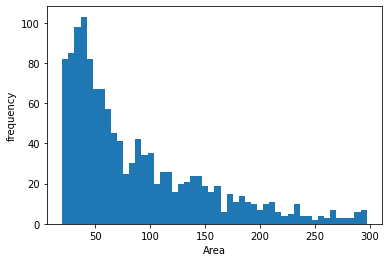

In [18]:
nodulesize=[np.sum(mask) for mask in nodulemasks]
plt.hist([nod for nod in nodulesize if nod<300],bins=50)
plt.xlabel("Area")
plt.ylabel("frequency")
plt.show()
#remove samples with nodulesize<25, which is ~radius=2.8
#filteredindicies=[i for i in range(len(nodulesize)) if nodulesize[i]>25]
#noduleimages=noduleimages[filteredindicies]
#nodulemasks=nodulemasks[filteredindicies]



In [19]:
# noduleimages=noduleimages.reshape(noduleimages.shape[0],1,512,512)
# nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],1,512,512)

if K.image_data_format()=='channels_last':
    noduleimages=noduleimages.reshape(noduleimages.shape[0],512,512,1)
    nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],512,512,1)
else:
    noduleimages=noduleimages.reshape(noduleimages.shape[0],1,512,512)
    nodulemasks=nodulemasks.reshape(nodulemasks.shape[0],1,512,512)


imagestrain, imagestest, maskstrain, maskstest = train_test_split(noduleimages,nodulemasks,test_size=.20)

maskstrain.shape



(1288, 1, 512, 512)

In [35]:
noduleimages = None
nodulemasks = None
# imagestrain= imagestest= maskstrain= maskstest = None

In [20]:
maskstrain = maskstrain.astype(np.int8)
maskstest = maskstest.astype(np.int8)

In [21]:
# if K.image_data_format()=='channels_last':
#     maskstest = np.reshape( maskstest, [maskstest.shape[0], 512, 512,1])
#     imagestest = np.reshape( imagestest, [imagestest.shape[0], 512, 512,1])
#     imagestrain = np.reshape( imagestrain, [imagestrain.shape[0], 512, 512,1])
#     maskstrain = np.reshape( maskstrain, [maskstrain.shape[0], 512, 512,1])

imagestrain.shape, maskstrain.shape, imagestest.shape, maskstest.shape


((1288, 1, 512, 512),
 (1288, 1, 512, 512),
 (323, 1, 512, 512),
 (323, 1, 512, 512))

In [ ]:

# if K.image_data_format()=='channels_last':
#     plt.imshow(np.squeeze(maskstest[0]),cmap="gray")
# else:
#     plt.imshow(maskstest[0,0],cmap="gray")

Ground Truth test


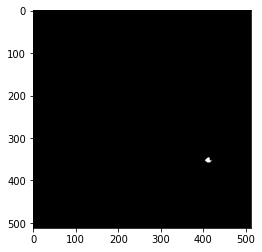

Image test


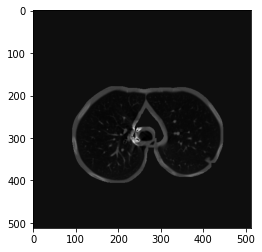

Ground Truth test


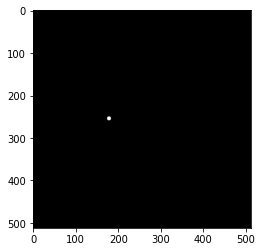

Image test


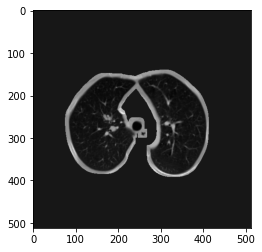

Ground Truth test


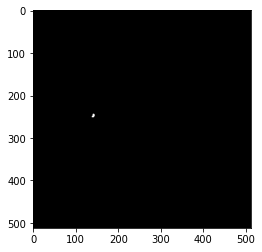

Image test


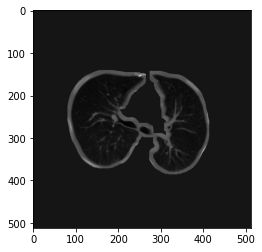

Ground Truth train


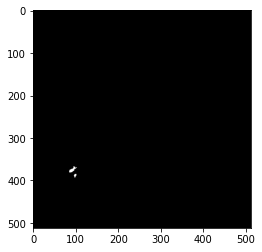

Image train


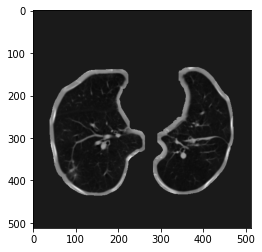

Ground Truth train


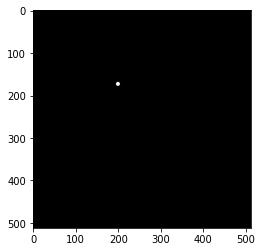

Image train


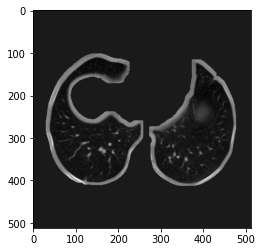

Ground Truth train


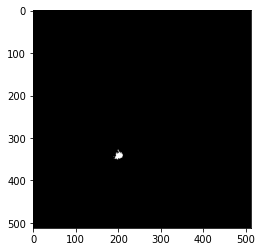

Image train


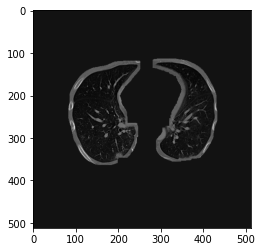

In [22]:

num_test=imagestest.shape[0]
num_train=imagestrain.shape[0]

num_test=3
num_train=3
if K.image_data_format()=='channels_last':
    for index in range(num_test):
        print("Ground Truth test")
        plt.imshow(np.squeeze(maskstest[index]),cmap="gray")
        plt.show()
        print("Image test")
        plt.imshow(np.squeeze(imagestest[index]), cmap="gray")
        plt.show()
            
    for index in range(num_test):
        print("Ground Truth train")
        plt.imshow(np.squeeze(maskstrain[index]),cmap="gray")
        plt.show()
        print("Image train")
        plt.imshow(np.squeeze(imagestrain[index]), cmap="gray")
        plt.show()
else:
    for index in range(num_test):
        print("Ground Truth test")
        plt.imshow(maskstest[index,0],cmap="gray")
        plt.show()
        print("Image test")
        plt.imshow(imagestest[index,0], cmap="gray")
        plt.show()
            
    for index in range(num_test):
        print("Ground Truth train")
        plt.imshow(maskstrain[index,0],cmap="gray")
        plt.show()
        print("Image train")
        plt.imshow(imagestrain[index,0], cmap="gray")
        plt.show()



In [23]:
#Code sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
smooth = 1.0
width = 32

def dice_coef(y_true, y_pred):
    y_true =tf.cast(y_true, tf.float32)
    y_pred =tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    # y_true =y_true.astype(float)
    # y_pred =y_pred.astype(float)
    return -dice_coef(y_true, y_pred)


def unet_model():
    if K.image_data_format()=='channels_first':
        input_shape = (1,512, 512)
        print((1,512, 512))
    else:
        input_shape = (512, 512,1)
        print((512, 512,1))

    inputs = Input(input_shape)
    # inputs = Input((1,512, 512))
    conv1 = Conv2D(width, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Conv2D(width, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2), strides = (2,2), padding = 'same')(conv1)

    conv2 = Conv2D(width*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Conv2D(width*2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(width*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Conv2D(width*4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2), strides = (2,2), padding = 'same')(conv3)

    conv4 = Conv2D(width*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Conv2D(width*8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2,2), strides = (2,2), padding = 'same')(conv4)
    print(conv4.shape, pool4.shape)

    conv5 = Conv2D(width*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization(axis = 1)(conv5)
    conv5 = Conv2D(width*16, (3, 3), activation='relu', padding='same')(conv5)
    print(conv5.shape, conv4.shape)
    # pool5 = MaxPooling2D((2,2), strides = (2,2), padding = 'same')(conv5)
    up = UpSampling2D(size=(2, 2))(conv5)
    print(up.shape, conv4.shape)

    # up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    up6 = tf.keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    print(up6)
    conv6 = SpatialDropout2D(0.35)(up6)
    conv6 = Conv2D(width*8, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(width*8, (3, 3), activation='relu', padding='same')(conv6)

    # up7 = Concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    up7 = tf.keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = SpatialDropout2D(0.35)(up7)
    conv7 = Conv2D(width*4, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Conv2D(width*4, (3, 3), activation='relu', padding='same')(conv7)

    # up8 = Concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = tf.keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = SpatialDropout2D(0.35)(up8)
    conv8 = Conv2D(width*2, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Conv2D(width*2, (3, 3), activation='relu', padding='same')(conv8)

    # up9 = Concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = tf.keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = SpatialDropout2D(0.35)(up9)
    conv9 = Conv2D(width, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(width, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)


    unet = Model(inputs=inputs, outputs=conv10)
    # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    return unet

unet=unet_model()
unet.summary()




(1, 512, 512)
(None, 256, 64, 64) (None, 256, 32, 32)
(None, 512, 32, 32) (None, 256, 64, 64)
(None, 512, 64, 64) (None, 256, 64, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 768, 64, 64), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 512, 512) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 512, 512) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 512, 512) 128         conv2d[0][0]               

In [24]:
model = unet
filepath=weightsfolder+"/unet-unet-"+K.image_data_format()+"-weights-improvement_"+pf_last+".hdf5"

load_status = model.load_weights(filepath)

# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])

In [26]:
unet.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
filepath=weightsfolder+"/unet-unet"+K.image_data_format()+"-weights-improvement_"+pf+".hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
history_unet = unet.fit(imagestrain, maskstrain, batch_size=4, epochs=10, verbose=1, shuffle=True,
              callbacks=[checkpoint],validation_data=(imagestest,maskstest))
K.clear_session()


Epoch 1/10
322/322 [==============================] - 386s 1s/step - loss: -0.5125 - dice_coef: 0.5125 - val_loss: -0.4905 - val_dice_coef: 0.4903

Epoch 00001: loss improved from inf to -0.51874, saving model to /content/drive/MyDrive/out/LungNoduleDetectionClassification/modelweights/unet-unetchannels_first-weights-improvement_0201_0399.hdf5
Epoch 2/10
322/322 [==============================] - 383s 1s/step - loss: -0.5742 - dice_coef: 0.5742 - val_loss: -0.5173 - val_dice_coef: 0.5166

Epoch 00002: loss improved from -0.51874 to -0.56644, saving model to /content/drive/MyDrive/out/LungNoduleDetectionClassification/modelweights/unet-unetchannels_first-weights-improvement_0201_0399.hdf5
Epoch 3/10
322/322 [==============================] - 384s 1s/step - loss: -0.6085 - dice_coef: 0.6085 - val_loss: -0.5460 - val_dice_coef: 0.5455

Epoch 00003: loss improved from -0.56644 to -0.60100, saving model to /content/drive/MyDrive/out/LungNoduleDetectionClassification/modelweights/unet-unetch

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


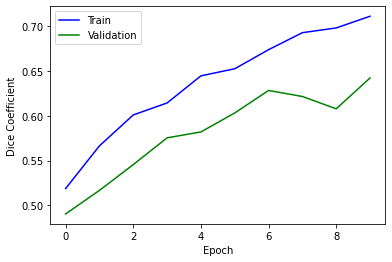

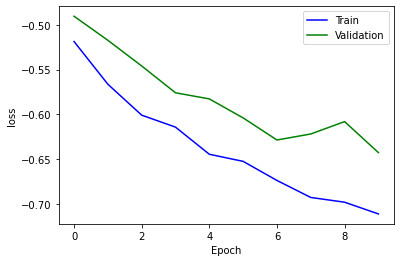

In [27]:
history_unet
print(history_unet.history.keys())
# model.save(weightsfolder+"/unet-weights-improvement_2_last.hdf5")
plt.plot(history_unet.history['dice_coef'], color='b')
plt.plot(history_unet.history['val_dice_coef'], color='g')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.legend(["Train", "Validation"])
plt.show()


# plt.plot(history_unet.history['accuracy'], color='b')
# plt.plot(history_unet.history['val_accuracy'], color='g')
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend(["Train", "Validation"])
# plt.show()

plt.plot(history_unet.history['loss'], color='b')
plt.plot(history_unet.history['val_loss'], color='g')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(["Train", "Validation"])
plt.show()

In [22]:
# from tensorflow.keras import layers


# def get_model(img_size, num_classes):
    
#     if K.image_data_format()=='channels_first':
#         input_shape = (1,512, 512)
#         print((1,512, 512))
#     else:
#         input_shape = (512, 512,1)
#         print((512, 512,1))

#     inputs = Input(input_shape)

#     ### [First half of the network: downsampling inputs] ###
#     # Entry block
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

#     # Define the model
#     model = Model(inputs, outputs)
#     return model


# # Free up RAM in case the model definition cells were run multiple times
# K.clear_session()

# # Build model
# model = get_model((512,512), 1)
# model.summary()

(1, 512, 512)


In [ ]:
# # Train model on dataset with only nodules

# filepath=weightsfolder+"/unet-"+K.image_data_format()+"-weights-improvement_2.hdf5"
# # model.load_weights(filepath)

# # model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])
# # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])
# # model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[dice_coef, 'accuracy'] )
# # model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])



# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
# history=model.fit(imagestrain, maskstrain, batch_size=4, epochs=10, verbose=1, shuffle=True,
#               callbacks=[checkpoint],validation_data=(imagestest,maskstest))
# #history=model.fit_generator(generator(batch_size=batchsize), steps_per_epoch=len(nonzeroindex)/batchsize-batchsize*11, nb_epoch=1, callbacks=callbacks_list)

In [ ]:
# # Train model on dataset with only nodules
# umode=unet_model()
# filepath=weightsfolder+"/umode_unet-weights-improvement_2.hdf5"
# #model.load_weights(filepath)

# umode.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])
# # model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])


# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True)
# history=umode.fit(imagestrain, maskstrain, batch_size=4, epochs=20, verbose=1, shuffle=True,
#               callbacks=[checkpoint],validation_data=(imagestest,maskstest))
# #history=model.fit_generator(generator(batch_size=batchsize), steps_per_epoch=len(nonzeroindex)/batchsize-batchsize*11, nb_epoch=1, callbacks=callbacks_list)

In [28]:
K.clear_session()
model = unet

In [ ]:
# history
# print(history.history.keys())
# # model.save(weightsfolder+"/unet-weights-improvement_2_last.hdf5")
# plt.plot(history.history['dice_coef'], color='b')
# plt.plot(history.history['val_dice_coef'], color='g')
# plt.xlabel("Epoch")
# plt.ylabel("Dice Coefficient")
# plt.legend(["Train", "Validation"])
# plt.show()


# # plt.plot(history.history['accuracy'], color='b')
# # plt.plot(history.history['val_accuracy'], color='g')
# # plt.xlabel("Epoch")
# # plt.ylabel("Accuracy")
# # plt.legend(["Train", "Validation"])
# # plt.show()

# plt.plot(history.history['loss'], color='b')
# plt.plot(history.history['val_loss'], color='g')
# plt.xlabel("Epoch")
# plt.ylabel("loss")
# plt.legend(["Train", "Validation"])
# plt.show()

In [29]:
model.evaluate(imagestest,maskstest, batch_size=4)

81/81 [==============================] - 33s 406ms/step - loss: -0.6428 - dice_coef: 0.6423


[-0.6428437232971191, 0.6423303484916687]

In [30]:
imagestest.shape

# imagestest[1][360:375, 300:330]

(323, 1, 512, 512)

In [31]:

if K.image_data_format()=='channels_last':

    num_test=imagestest.shape[0]
    imgs_mask_test = np.ndarray([num_test,512,512,1],dtype=np.float32)

    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

    print(imgs_mask_test.shape)

    sumoverlap=[]
    for i in range(num_test):
        sumoverlap.append(np.sum(maskstest[i]*imgs_mask_test[i]))

    #nodulemasks
    print(len([ov for ov in sumoverlap if ov>1])/len(sumoverlap))

else:
    num_test=imagestest.shape[0]
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)

    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

    # print(imgs_mask_test.shape)

    sumoverlap=[]
    for i in range(num_test):
        sumoverlap.append(np.sum(maskstest[i,0]*imgs_mask_test[i,0]))

    #nodulemasks
    print(len([ov for ov in sumoverlap if ov>1])/len(sumoverlap))

0.7058823529411765


Predicted


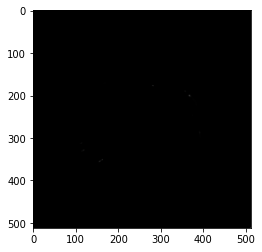

Ground Truth


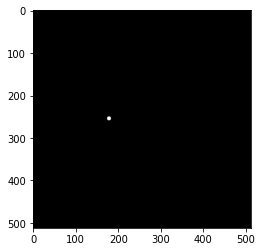

Image


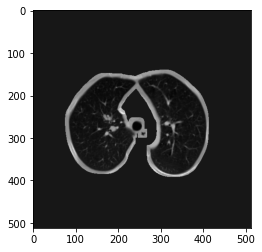

In [33]:
#Visualize prediction mask

index=1

if K.image_data_format()=='channels_last':
    print("Predicted")
    plt.imshow(np.squeeze(imgs_mask_test[index]), cmap="gray")
    plt.show()
    print("Ground Truth")
    plt.imshow(np.squeeze(maskstest[index]),cmap="gray")
    plt.show()
    print("Image")
    plt.imshow(np.squeeze(imagestest[index]), cmap="gray")
    plt.show()
else:
    print("Predicted")
    plt.imshow(imgs_mask_test[index,0], cmap="gray")
    plt.show()
    print("Ground Truth")
    plt.imshow(maskstest[index,0],cmap="gray")
    plt.show()
    print("Image")
    plt.imshow(imagestest[index,0], cmap="gray")
    plt.show()




0
Predicted


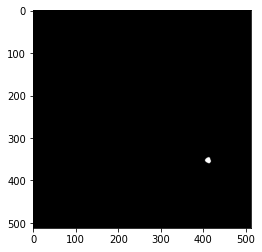

Ground Truth


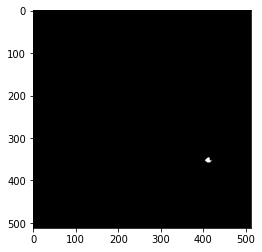

Image


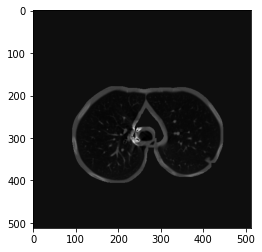

------------------------------------------
1
Predicted


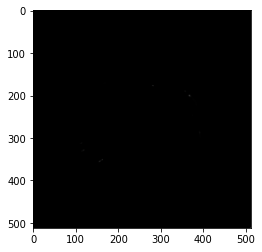

Ground Truth


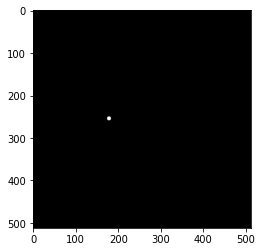

Image


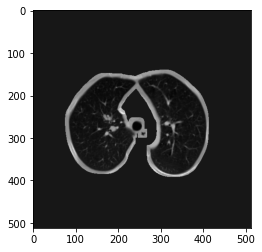

------------------------------------------
2
Predicted


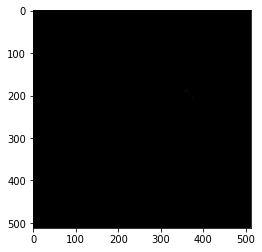

Ground Truth


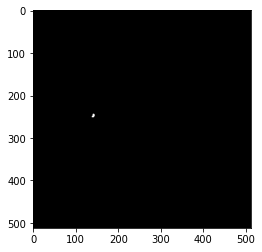

Image


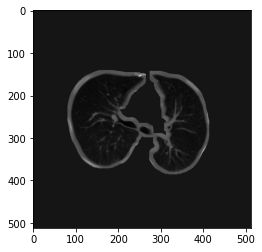

------------------------------------------
3
Predicted


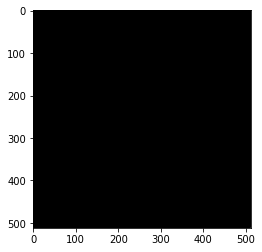

Ground Truth


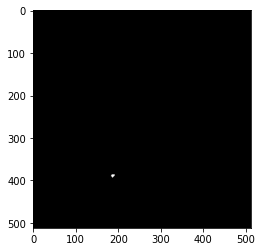

Image


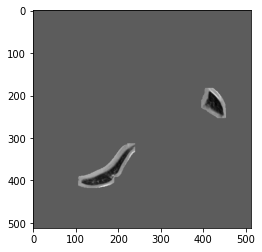

------------------------------------------
4
Predicted


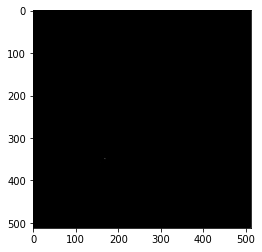

Ground Truth


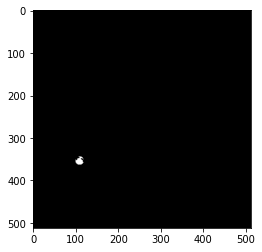

Image


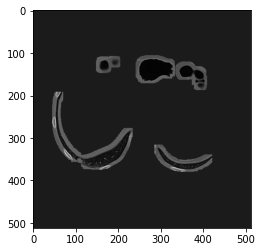

------------------------------------------
5
Predicted


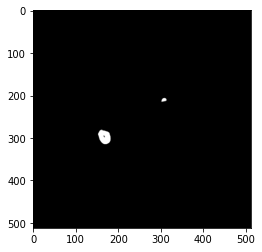

Ground Truth


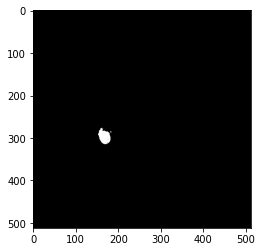

Image


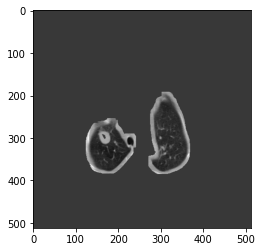

------------------------------------------
6
Predicted


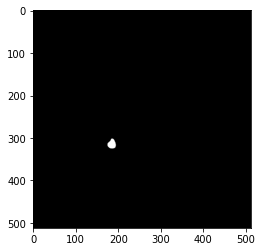

Ground Truth


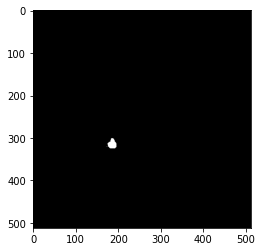

Image


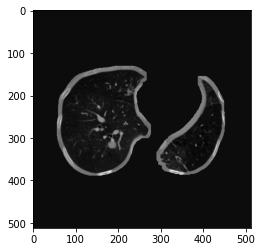

------------------------------------------
7
Predicted


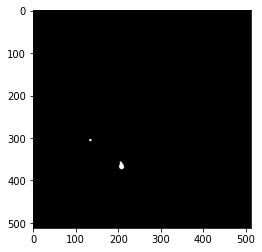

Ground Truth


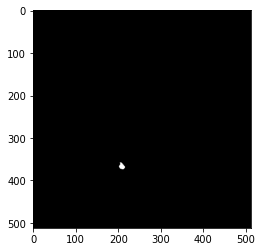

Image


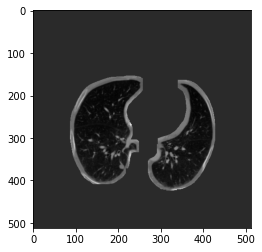

------------------------------------------
8
Predicted


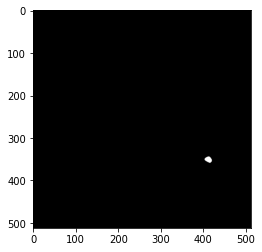

Ground Truth


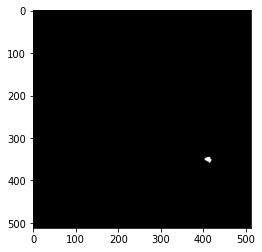

Image


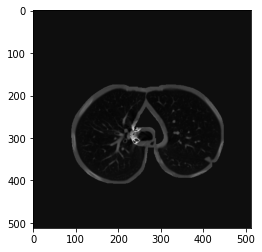

------------------------------------------
9
Predicted


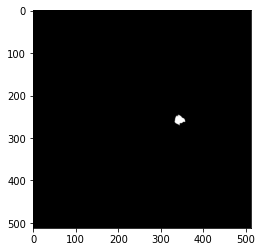

Ground Truth


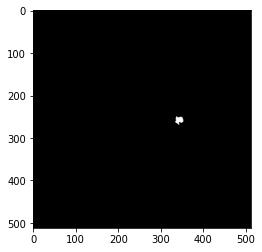

Image


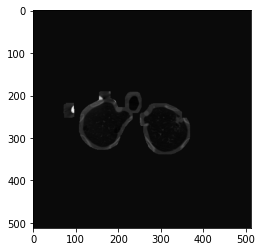

------------------------------------------


In [34]:
for i in range(10):
    print(i)
    if K.image_data_format()=='channels_last':
        print("Predicted")
        plt.imshow(np.squeeze(imgs_mask_test[i]), cmap="gray")
        plt.show()
        print("Ground Truth")
        plt.imshow(np.squeeze(maskstest[i]),cmap="gray")
        plt.show()
        print("Image")
        plt.imshow(np.squeeze(imagestest[i]), cmap="gray")
        plt.show()
    else:
        print("Predicted")
        plt.imshow(imgs_mask_test[i,0], cmap="gray")
        plt.show()
        print("Ground Truth")
        plt.imshow(maskstest[i,0],cmap="gray")
        plt.show()
        print("Image")
        plt.imshow(imagestest[i,0], cmap="gray")
        plt.show()
    print("------------------------------------------")

MODEL Z PLIKU:

In [35]:
model_old = model
# model = unet

# filepath=weightsfolder+"/unet-unet-"+K.image_data_format()+"-weights-improvement_2.hdf5"
filepath=weightsfolder+"/unet-unet"+K.image_data_format()+"-weights-improvement_"+pf+".hdf5"

load_status = model.load_weights(filepath)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',dice_coef])

# fmodel = tf.keras.models.load_model(filepath)
model.evaluate(imagestest,maskstest, batch_size=4)

81/81 [==============================] - 34s 412ms/step - loss: 13.2166 - accuracy: 0.0187 - dice_coef: 0.6413


[12.671432495117188, 0.014379353262484074, 0.6423303484916687]

In [36]:
model.evaluate(imagestrain, maskstrain, batch_size=4)

322/322 [==============================] - 132s 408ms/step - loss: 9.2881 - accuracy: 0.0134 - dice_coef: 0.7118


[9.288052558898926, 0.013423184864223003, 0.7117733955383301]

In [37]:
if K.image_data_format()=='channels_last':

    num_test=imagestest.shape[0]
    imgs_mask_test = np.ndarray([num_test,512,512,1],dtype=np.float32)

    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

    print(imgs_mask_test.shape)

    sumoverlap=[]
    for i in range(num_test):
        sumoverlap.append(np.sum(maskstest[i]*imgs_mask_test[i]))

    #nodulemasks
    print(len([ov for ov in sumoverlap if ov>1])/len(sumoverlap))

else:
    num_test=imagestest.shape[0]
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)

    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imagestest[i:i+1]], verbose=0)[0]

    # print(imgs_mask_test.shape)

    sumoverlap=[]
    for i in range(num_test):
        sumoverlap.append(np.sum(maskstest[i,0]*imgs_mask_test[i,0]))

    #nodulemasks
    print(len([ov for ov in sumoverlap if ov>1])/len(sumoverlap))

0.7058823529411765


0
Predicted


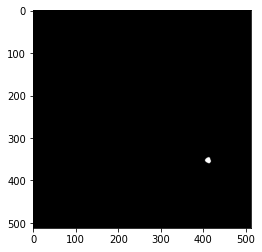

Ground Truth


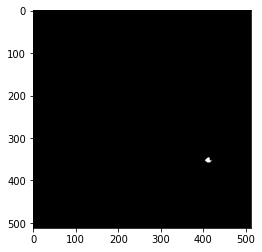

Image


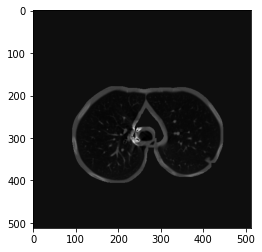

------------------------------------------
1
Predicted


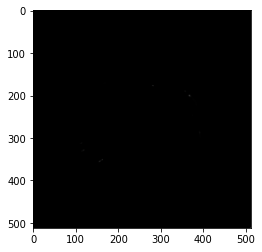

Ground Truth


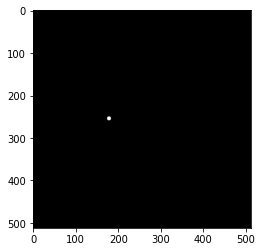

Image


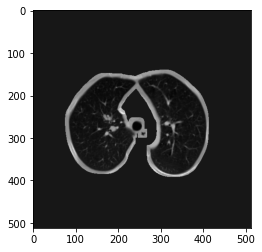

------------------------------------------
2
Predicted


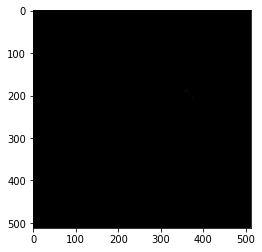

Ground Truth


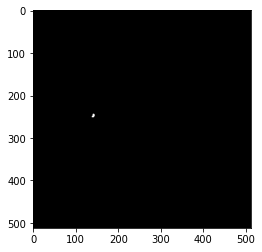

Image


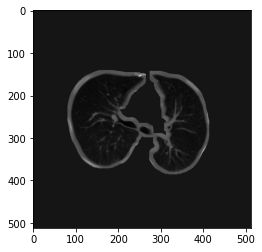

------------------------------------------
3
Predicted


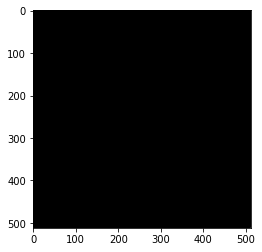

Ground Truth


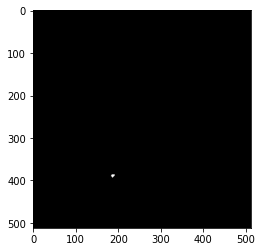

Image


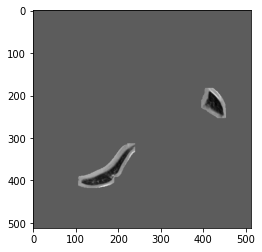

------------------------------------------
4
Predicted


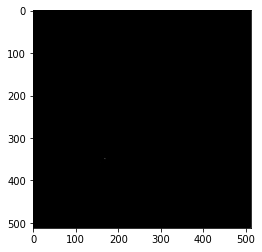

Ground Truth


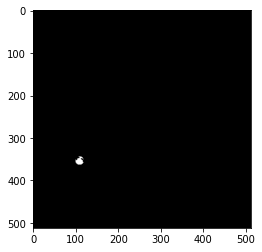

Image


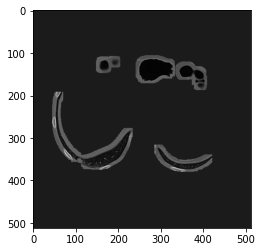

------------------------------------------
5
Predicted


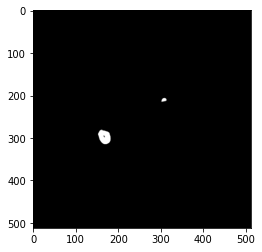

Ground Truth


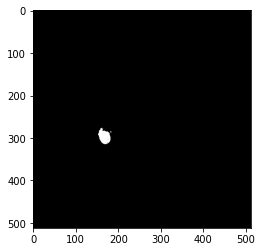

Image


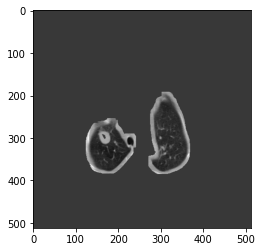

------------------------------------------
6
Predicted


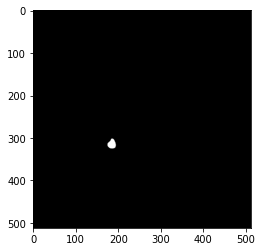

Ground Truth


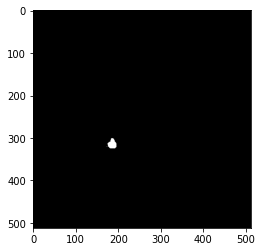

Image


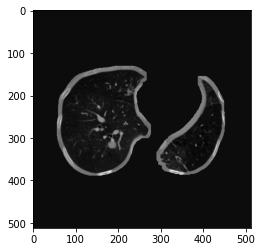

------------------------------------------
7
Predicted


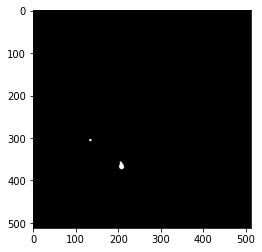

Ground Truth


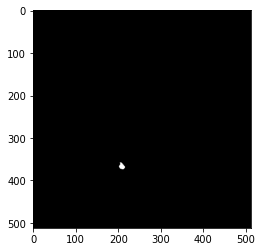

Image


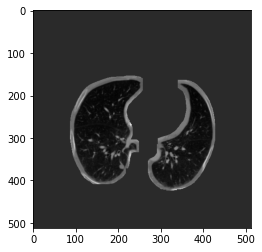

------------------------------------------
8
Predicted


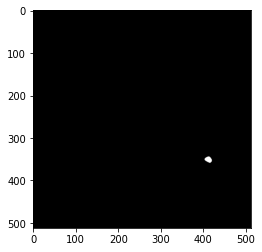

Ground Truth


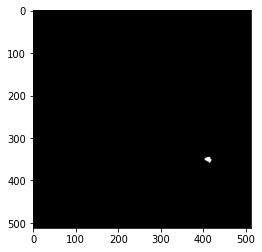

Image


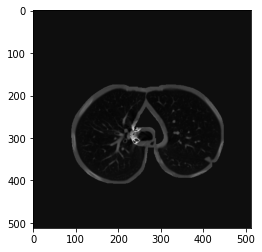

------------------------------------------
9
Predicted


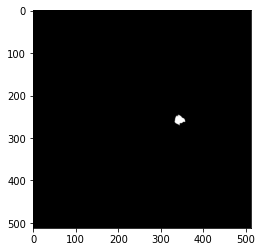

Ground Truth


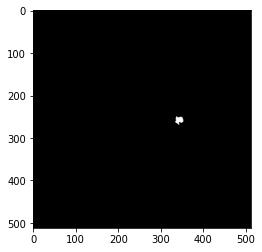

Image


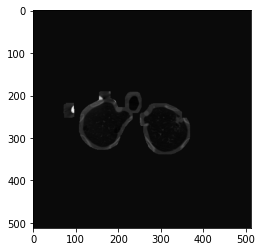

------------------------------------------


In [38]:
for i in range(10):
    print(i)
    if K.image_data_format()=='channels_last':
        print("Predicted")
        plt.imshow(np.squeeze(imgs_mask_test[i]), cmap="gray")
        plt.show()
        print("Ground Truth")
        plt.imshow(np.squeeze(maskstest[i]),cmap="gray")
        plt.show()
        print("Image")
        plt.imshow(np.squeeze(imagestest[i]), cmap="gray")
        plt.show()
    else:
        print("Predicted")
        plt.imshow(imgs_mask_test[i,0], cmap="gray")
        plt.show()
        print("Ground Truth")
        plt.imshow(maskstest[i,0],cmap="gray")
        plt.show()
        print("Image")
        plt.imshow(imagestest[i,0], cmap="gray")
        plt.show()
    print("------------------------------------------")